# Ajuste de Timbre mediante Formantes

In [3]:
from google.colab import userdata

dir_files = '/content/audiopfinal/data'


token = userdata.get('ghToken')
!git clone https://{token}@github.com/Cosuki/audiopfinal.git > /dev/null 2>&1

In [2]:
!pip install libtsm > /dev/null 2>&1

import numpy as np
import matplotlib.pyplot as plt
from scipy import io, signal
import scipy.fft
from IPython.display import Audio
from scipy.linalg import toeplitz, solve
import libtsm

In [13]:
# Directorio de archivos (Colab)
dir_files = '/content/audiopfinal/data/'

In [4]:
def cargar_audio(directorio, nombre, mono=False):
    # Cargar audio
    sr, data = io.wavfile.read(directorio+nombre)

    if mono:
        # Pasar de estéreo a mono
        if len(data.shape) > 1:
            data = (data[:,0].astype(float) + data[:,1].astype(float))/2

    # normalize maximum (absolute) amplitude
    data = data / np.max(abs(data)) * 0.9

    return sr, data

In [5]:
def lpc_analysis(s, p=20):
    """ compute the LPC analysis using the autocorrelation method

    Parameters
    ----------
    x : numpy array
        windowed signal frame as a numpy 1D array.
    p : int
        model order.

    Returns
    -------
    ak : numpy array
         model coefficients.
    e : float
        minimum mean squared error.
    e_norm : float
             normalized minimum mean squared error.
    """
    # frame length
    N = s.shape[0]

    # compute autocorrelation values
    r = np.zeros((p+1, 1))
    for k in range(p+1):
        r[k] = np.dot(s[:N-k].T, s[k:])

    # solve to compute model coefficients
    ak = solve(toeplitz(r[:p]), r[1:]).squeeze()

    # compute mean squared error
    e = r[0] - np.dot(ak.T, r[1:])

    # compute normalized mean squared error
    e_norm = e / r[0]

    return ak, e, e_norm

In [6]:
def lpc_decomposition(s_win, ak, e, fs, Ndft, Nw):
    # filter obtained from the lpc analysis
    S = 1
    U = np.concatenate([[1], -ak])

    # compute gain
    G = np.sqrt(e)

    # compute the frequency response of the digital filter
    w, H = signal.freqz(G*S, U, worN=Ndft, whole=True)
    fw = w / (2 * np.pi) * fs

    # impulse response of the LPC filter
    delta = np.zeros(Nw)
    delta[0] = 1
    h = signal.lfilter(G*S, U, delta)

    # magnitude spectrum
    magH = np.abs(H)
    ind_fmx = int(Ndft/2)

    # inverse filter
    A = S*G
    B = U

    # compute the excitation from the inverse filter
    p = signal.lfilter(B, A, s_win)

    # compute the spectrum of the excitation
    P = np.fft.fft(p, Ndft)

    return H, P

In [7]:
def analysis_STFT_LPC(x, fs, L=2048, R=256, win='hann'):
    """ compute the analysis phase of the phase vocoder, i.e. the STFT of the input audio signal

    Parameters
    ----------
    x : numpy array
        input audio signal (mono) as a numpy 1D array.
    L : int
        window length in samples.
    R : int
        hop size in samples.
    win : string
          window type as defined in scipy.signal.windows.

    Returns
    -------
    X_stft : numpy array
             STFT of x as a numpy 2D array.
    omega_stft : numpy array
                 frequency values in radians.
    samps_stft : numpy array
                 time sample at the begining of each frame.

    """

    # length of the input signal
    M = x.size;

    # number of points to compute the DFT (FFT)
    N = L

    # analysis window
    window = signal.windows.get_window(win, L)

    # total number of analysis frames
    num_frames = int(np.floor((M - L) / R))

    # initialize stft
    X_stft = np.zeros((N, num_frames), dtype = complex)
    X_env = np.zeros((N, num_frames), dtype = complex)
    X_exc = np.zeros((N, num_frames), dtype = complex)

    # process each frame
    for ind in range(num_frames):

        # initial and ending points of the frame
        n_ini = int(ind * R)
        n_end = n_ini + L

        # signal frame
        xr = window*x[n_ini:n_end]

        # save DFT of the signal frame
        X_stft[:, ind] = scipy.fft.fft(xr, N)

        # LPC
        if np.max(abs(xr))>1e-8:
            ak, e, _ = lpc_analysis(xr, p=20)
            X_env[:, ind], X_exc[:, ind] = lpc_decomposition(xr, ak, e, fs, N, N)

    # frequency values in radians
    omega_stft = 2*np.pi*np.arange(N)/N

    # time sample at the center of each frame
    samps_stft = np.arange(L/2, M-L/2, R)[:-1]

    return X_stft, X_env, X_exc, omega_stft, samps_stft

In [8]:
def synthesis_STFT(X_stft, L=2048, R=256, win='hann'):
    """ compute the synthesis using the IFFT of each frame combined with overlap-add

    Parameters
    ----------
    X_stft : numpy array
             STFT of x as a numpy 2D array.
    L : int
        window length in samples.
    R : int
        hop size in samples.
    win : string
          window type as defined in scipy.signal.windows.

    Returns
    -------
    x : numpy array
        output audio signal (mono) as a numpy 1D array.

    """

    # number of frequency bins
    N = X_stft.shape[0];

    # analysis window
    window = signal.windows.get_window(win, L)

    # total number of analysis frames
    num_frames = X_stft.shape[1]

    # initialize otuput signal in the time domain
    y = np.zeros(num_frames * R + L)

    # process each frame
    for ind in range(num_frames):

        # reconstructed signal frame
        yr = scipy.fft.ifft(X_stft[:,ind], L).real

        # initial and ending points of the frame
        n_ini = ind*R
        n_end = ind*R + L

        # overlap-add the signal frame
        y[n_ini:n_end] += window*yr

    # compute the amplitude scaling factor
    C = (L/2)/R

    # compensate the amplitude scaling factor
    y /= C

    return y

In [ ]:
sr, x = cargar_audio(dir_files, 'Emily_Linge-vocals.wav', mono=True)
Audio(x, rate=sr)

## Shifteo la pista

In [ ]:
opt_chroma_shift = 2
pitch_shift_for_audio_1 = -opt_chroma_shift % 12
pitch_shift_for_audio_1 -= 12
xs = libtsm.pitch_shift(x, pitch_shift_for_audio_1 * 100, order="tsm-res")
Audio(xs[:,0], rate=sr)

## Calculo LPC a la original y shifteada
Genero psita ajustada en funcion de la exitacion de la shifteada y la envolvente de la original

In [ ]:
L = 2048
R = 256

X_stft, X_env, X_exc, _, _ = analysis_STFT_LPC(x, sr, L, R)
Xs_stft, Xs_env, Xs_exc, _, _ = analysis_STFT_LPC(xs[:,0], sr, L, R)

Xm_stft = Xs_exc*X_env

xm = synthesis_STFT(Xm_stft, L, R)
Audio(xm, rate=sr)

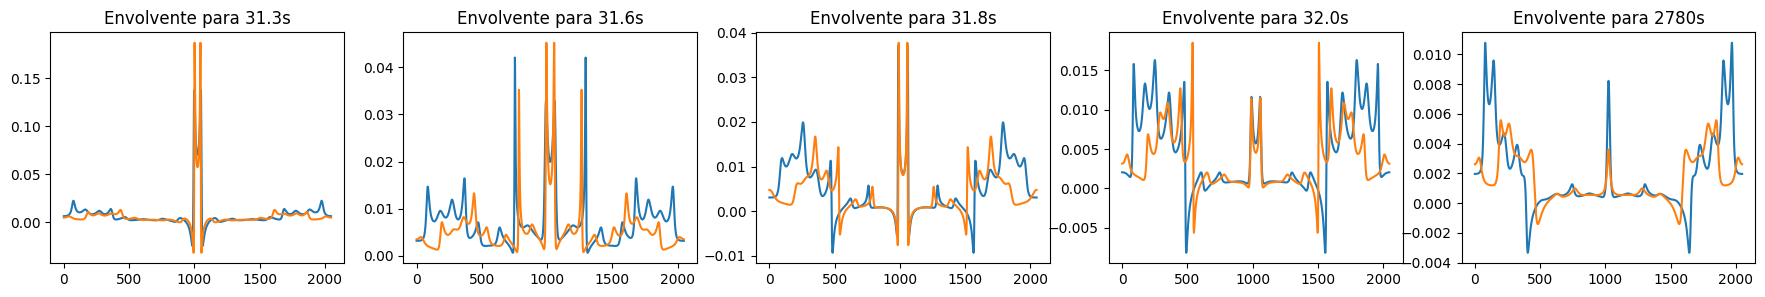

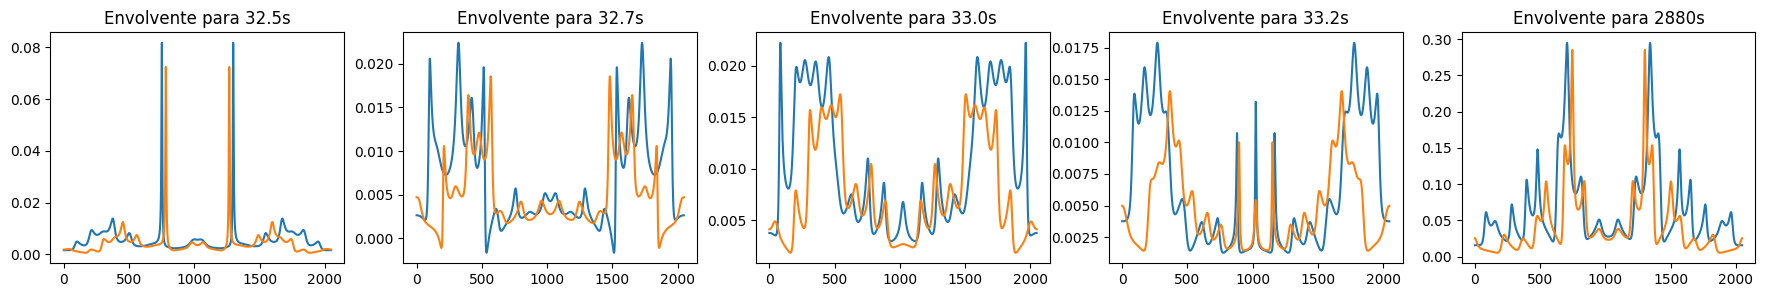

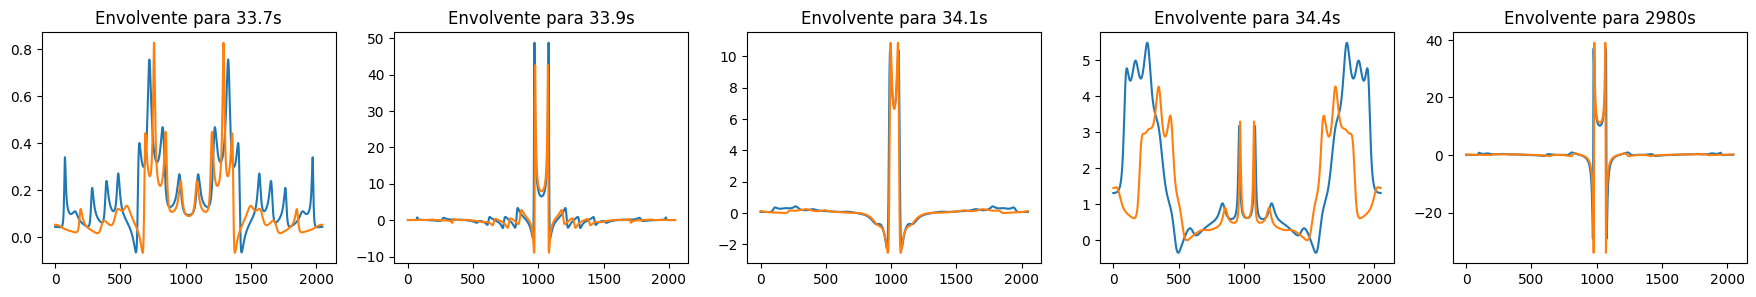

In [69]:

for i in np.arange(start=2700, stop=3000, step=100):
    fig, axs = plt.subplots(1, 5, figsize=(22, 3))
    axs[0].plot(np.fft.fftshift(X_env[:,i]))
    axs[0].plot(np.fft.fftshift(Xs_env[:,i]))
    axs[0].set_title(f'Envolvente para {round((i)*R/sr, 1)}s')
    axs[1].plot(np.fft.fftshift(X_env[:,i+20]))
    axs[1].plot(np.fft.fftshift(Xs_env[:,i+20]))
    axs[1].set_title(f'Envolvente para {round((i+20)*R/sr, 1)}s')
    axs[2].plot(np.fft.fftshift(X_env[:,i+40]))
    axs[2].plot(np.fft.fftshift(Xs_env[:,i+40]))
    axs[2].set_title(f'Envolvente para {round((i+40)*R/sr, 1)}s')
    axs[3].plot(np.fft.fftshift(X_env[:,i+60]))
    axs[3].plot(np.fft.fftshift(Xs_env[:,i+60]))
    axs[3].set_title(f'Envolvente para {round((i+60)*R/sr, 1)}s')
    axs[4].plot(np.fft.fftshift(X_env[:,i+80]))
    axs[4].plot(np.fft.fftshift(Xs_env[:,i+80]))
    axs[4].set_title(f'Envolvente para {i+80}s')
    plt.show()

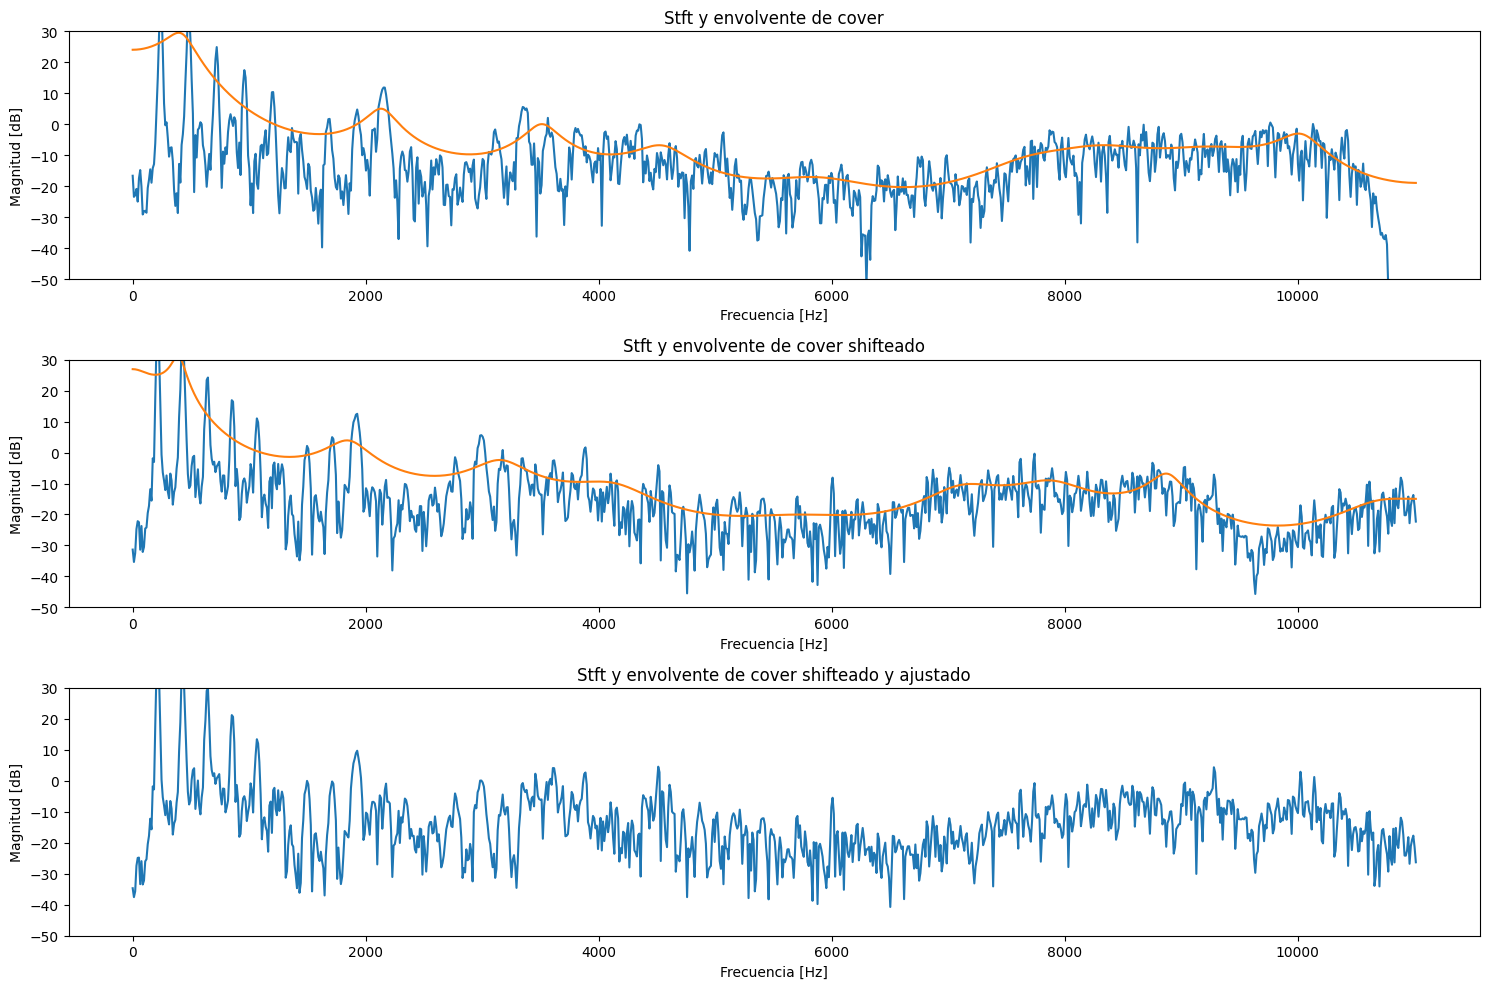

In [131]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
i = 2600

shift = lambda x, i: abs(x[:, i])

sigEnv = 20*np.log10(shift(X_env, i))
sigExc = 20*np.log10(shift(X_exc, i))
sigStft = 20*np.log10(shift(X_stft, i))
f = np.fft.fftfreq(len(sigStft), 1/sr)
axs[0].plot(f[:len(f)//2], sigStft[:len(sigStft)//2])
axs[0].plot(f[:len(f)//2], sigEnv[:len(sigEnv)//2])
# axs[0].plot(sigExc)
axs[0].set_ylim(-50, 30)
axs[0].set_title('Stft y envolvente de cover')
axs[0].set_ylabel('Magnitud [dB]')
axs[0].set_xlabel('Frecuencia [Hz]')

sigEnv = 20*np.log10(shift(Xs_env, i))
sigExc = 20*np.log10(shift(Xs_exc, i))
sigStft = 20*np.log10(shift(Xs_stft, i))
axs[1].plot(f[:len(f)//2], sigStft[:len(sigStft)//2])
axs[1].plot(f[:len(f)//2], sigEnv[:len(sigEnv)//2])
# axs[1].plot(sigExc)
axs[1].set_ylim(-50, 30)
axs[1].set_title('Stft y envolvente de cover shifteado')
axs[1].set_ylabel('Magnitud [dB]')
axs[1].set_xlabel('Frecuencia [Hz]')

sigStft = 20*np.log10(shift(Xm_stft, i))
axs[2].plot(f[:len(f)//2], sigStft[:len(sigStft)//2])
axs[2].set_ylim(-50, 30)
axs[2].set_title('Stft y envolvente de cover shifteado y ajustado')
axs[2].set_ylabel('Magnitud [dB]')
axs[2].set_xlabel('Frecuencia [Hz]')

plt.tight_layout()
plt.show()